In [5]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import openml
import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jaxtyping import Array, Float, Int, PRNGKeyArray
import aeon
import pandas as pd
from preprocessing.timeseries_augmentation import normalize_mean_std_traindata, normalize_streams, augment_time, add_basepoint_zero
from aeon.regression.sklearn import RotationForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from aeon.datasets.tser_datasets import tser_soton
from aeon.datasets import load_regression, load_classification
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

from utils.utils import print_name, print_shape

jax.config.update('jax_platform_name', 'cpu') # Used to set the platform (cpu, gpu, etc.)
np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [6]:
# Fetch the collection with ID 353
collection = openml.study.get_suite(353)
dataset_ids = collection.data
metadata_list = []

# Fetch and process each dataset
for i, dataset_id in enumerate(dataset_ids):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute
    )
    X = np.array(X)
    y = np.array(y)[..., None]
    
    # Extract the required metadata
    metadata = {
        'dataset_id': dataset.id,
        'name': dataset.name,
        'n_obs': int(dataset.qualities['NumberOfInstances']),
        'n_features': int(dataset.qualities['NumberOfFeatures']),
        '%_unique_y': len(np.unique(y))/len(y),
        'n_unique_y': len(np.unique(y)),
    }
    
    metadata_list.append(metadata)
    print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# Create a DataFrame from the metadata list
df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False)

 1/35 Processed dataset 44956: abalone
 2/35 Processed dataset 44957: airfoil_self_noise
 3/35 Processed dataset 44958: auction_verification
 4/35 Processed dataset 44959: concrete_compressive_strength
 5/35 Processed dataset 44963: physiochemical_protein
 6/35 Processed dataset 44964: superconductivity
 7/35 Processed dataset 44965: geographical_origin_of_music
 8/35 Processed dataset 44966: solar_flare
 9/35 Processed dataset 44969: naval_propulsion_plant
 10/35 Processed dataset 44971: white_wine
 11/35 Processed dataset 44972: red_wine
 12/35 Processed dataset 44973: grid_stability
 13/35 Processed dataset 44974: video_transcoding
 14/35 Processed dataset 44975: wave_energy
 15/35 Processed dataset 44976: sarcos
 16/35 Processed dataset 44977: california_housing
 17/35 Processed dataset 44978: cpu_activity
 18/35 Processed dataset 44979: diamonds
 19/35 Processed dataset 44980: kin8nm
 20/35 Processed dataset 44981: pumadyn32nh
 21/35 Processed dataset 44983: miami_housing
 22/35 P

In [7]:
df_metadata.sort_values('%_unique_y', ascending=True)

,dataset_id,name,n_obs,n_features,%_unique_y,n_unique_y
9,44971,white_wine,4898,12,0.001429,7
26,44993,health_insurance,22272,12,0.003367,75
10,44972,red_wine,1599,12,0.003752,6
8,44969,naval_propulsion_plant,11934,15,0.004274,51
0,44956,abalone,4177,9,0.006703,28
16,44978,cpu_activity,8192,22,0.006836,56
27,45012,fifa,19178,29,0.006935,133
7,44966,solar_flare,1066,11,0.007505,8
31,44967,student_performance_por,649,31,0.026194,17
6,44965,geographical_origin_of_music,1059,117,0.029273,31


# Download single dataset

In [8]:
def load_openml_dataset(dataset_id, 
                        normalize_X:bool = True,
                        normalize_y:bool = True,
                        train_test_size:float = 0.7,
                        split_seed:int = 0) -> Tuple[np.ndarray, np.ndarray]:
    # Fetch dataset from OpenML by its ID
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    X = np.array(X)
    y = np.array(y)[..., None]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_size, random_state=split_seed)

    #normalize
    if normalize_X:
        X_train, X_test = normalize_mean_std_traindata(X_train, X_test)
    if normalize_y:
        y_train, y_test = normalize_mean_std_traindata(y_train, y_test)

    return (jnp.array(X_train.astype(np.float32)), 
            jnp.array(X_test.astype(np.float32)), 
            jnp.array(y_train.astype(np.float32)), 
            jnp.array(y_test.astype(np.float32)))

dataset_id = 44971  # Replace with the dataset ID you want
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id)


# SWIM tabular model

In [30]:
from typing import Tuple, List, Union, Any, Optional, Dict, Set, Literal, Callable
from abc import ABC, abstractmethod
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jaxtyping import Array, Float, Int, PRNGKeyArray



def init_single_SWIM_layer(
        seed: PRNGKeyArray,
        X: Float[Array, "N  d"],
        y: Float[Array, "N  p"],
        n_features: int,
        sampling_method: Literal["uniform", "gradient-weighted"] = "uniform",
    ) -> Tuple[Float[Array, "d  n_features"], Float[Array, "n_features"]]:
    """
    Fits the weights for a single layer of the SWIM model.

    Args:
        seed (PRNGKeyArray): Random seed for the weights and biases.
        X (Float[Array, "N  d"]): Previous layer's output.
        y (Float[Array, "N  p"]): Target training data.
        n_features (int): Next hidden layer size.
        sampling_method (str): Uniform or gradient-weighted pair sampling.
    Returns:
        Weights (d, n_features) and biases (1, n_features) for the next layer.
    """
    seed_idxs, seed_sample = jax.random.split(seed, 2)
    N, d = X.shape
    EPS = 0.01

    #obtain pair indices
    n = 3*N
    idx1 = jnp.arange(0, n) % N
    delta = jax.random.randint(seed_idxs, shape=(n,), minval=1, maxval=N)
    idx2 = (idx1 + delta) % N
    dx = X[idx2] - X[idx1]
    dists = jnp.linalg.norm(dx, axis=1, keepdims=True)
    dists = jnp.maximum(dists, EPS)
    
    if sampling_method=="gradient-weighted":
        #calculate 'gradients'
        dy = y[idx2] - y[idx1]

        gradients = (jnp.linalg.norm(dy, axis=1, keepdims=True) / dists ).reshape(-1) #NOTE paper uses ord=inf instead of ord=2
        print(gradients)
        print(jnp.max(gradients))
        print(jnp.min(gradients))
        p = gradients/gradients.sum()
        print(p)
        print(jnp.max(p))
        print(jnp.min(p))
    elif sampling_method=="uniform":
        p = None
    else:
        raise ValueError(f"sampling_method must be 'uniform' or 'gradient-weighted'. Given: {sampling_method}")

    #sample pairs
    selected_idx = jax.random.choice(
        seed_sample, 
        n,
        shape=(n_features,), 
        replace=True,
        p=p
        )
    print(selected_idx)
    idx1 = idx1[selected_idx]
    dx = dx[selected_idx]
    dists = dists[selected_idx]

    #define weights and biases
    weights = (dx / dists**2).T
    biases = -jnp.sum(weights * X[idx1].T, axis=0, keepdims=True) - 0.5  # NOTE experiment with this. also +-0.5 ?
    return weights, biases



def forward_1_layer(
        X: Float[Array, "N  d"],
        weights: Float[Array, "d  n_features"],
        biases: Float[Array, "1  n_features"],
        add_residual: bool,
        activation = lambda x : jnp.maximum(0,x+0.5), # jnp.tanh,
        scaling_factor: float = 1.0,
    ) -> Float[Array, "N  n_features"]:
    """
    Forward pass for a single layer of the SWIM model.
    """
    d, D = weights.shape
    X1 = activation(X @ weights + biases)
    if add_residual and d==D:
        print("residual")
        return scaling_factor*X1 + X
    else:
        print("not residual")
        return X1



def SWIM_all_layers(
        seed: PRNGKeyArray,
        X0: Float[Array, "N  d"],
        y: Float[Array, "N  p"],
        n_features: int,
        activation: Callable,
        n_layers: int,
        add_residual: bool,
        residual_scaling_factor: float = 1.0,
        sampling_method: Literal["uniform", "gradient-weighted"] = "gradient-weighted",
    ):
    """
    Fits the weights for the SWIM model, iteratively layer by layer

    Args:
        seed (PRNGKeyArray): Random seed for the weights and biases.
        X0 (Float[Array, "N  d"]): First layer input.
        y (Float[Array, "N  p"]): Target training data.
        n_features (int): Hidden layer size.
        activation (Callable): Activation function for the network.
        n_layers (int): Number of layers in the network.
        add_residual (bool): Whether to use residual connections.
        residual_scaling_factor (float): Scaling factor for the residual connections.
        sampling_method (str): Uniform or gradient-weighted pair sampling for weight initialization.

    Returns:
        Weights (d, n_features) and biases (1, n_features) for the next layer.
    """

    def scan_body(carry, seed): # (carry, x) -> (carry, y)
        X, y = carry
        w, b = init_single_SWIM_layer(seed, X, y, n_features, sampling_method)
        X = forward_1_layer(X, w, b, add_residual, activation, residual_scaling_factor)
        return (X, y), (w, b)

    init_carry = (X0, y)
    carry, WaB = lax.scan(
        scan_body,
        init_carry,
        xs=jax.random.split(seed, n_layers),
    )
    return WaB



class SWIM_MLP():
    def __init__(
            self,
            seed: PRNGKeyArray,
            n_features: int = 512,
            n_layers: int = 3,
            add_residual: bool = False,
            sampling_method: Literal["uniform", "gradient-weighted"] = "gradient-weighted",
            activation = lambda x : jnp.maximum(0,x+0.5), # jnp.tanh,
            residual_scaling_factor: Optional[float] = None,
        ):
        """Implementation of the original paper's SWIM model
        https://gitlab.com/felix.dietrich/swimnetworks-paper/,
        but with support for residual connections.

        Args:
            seed (PRNGKeyArray): Random seed for matrices, biases, initial value.
            n_features (int): Hidden layer dimension.
            n_layers (int): Number of layers in the network.
            add_residual (bool): Whether to use residual connections.
            sampling_method (str): Uniform or gradient-weighted pair sampling for weight initialization.
            activation (Callable): Activation function for the network.
            residual_scaling_factor (Optional[float]): Scaling factor for the residual skip connections.
        """
        self.n_features = n_features
        self.n_layers = n_layers
        self.seed = seed
        self.add_residual = add_residual
        self.sampling_method = sampling_method
        self.activation = activation
        self.w1 = None
        self.b1 = None
        self.weights = None
        self.biases = None
        self.residual_scaling_factor = 1/self.n_layers if residual_scaling_factor is None else residual_scaling_factor


    def fit(
            self, 
            X: Float[Array, "N  D"], 
            y: Float[Array, "N  p"]
        ):
        """
        Initializes MLP weights and biases, using SWIM algorithm.

        Args:
            X (Float[Array, "N  D"]): Input training data.
            y (Float[Array, "N  p"]): Target training data.
        """
        # Get shape, dtype
        seed1, seedrest = jax.random.split(self.seed, 2)

        #first do first layer, which cannot always be done in a scan loop
        self.w1, self.b1 = init_single_SWIM_layer(
            seed1, X, y, self.n_features, self.sampling_method
            )
        X = forward_1_layer(X, self.w1, self.b1, self.add_residual)
        
        #rest of the layers
        if self.n_layers > 1:
            self.weights, self.biases = SWIM_all_layers(
                seedrest, X, y, self.n_features, self.activation, self.n_layers-1, 
                self.add_residual, self.residual_scaling_factor, self.sampling_method
                )

        return self


    def transform(self, X: Float[Array, "N  D"], only_last=True) -> Float[Array, "N  n_features"]:
        #First hidden layer
        X = forward_1_layer(X, self.w1, self.b1, self.add_residual, self.activation, self.residual_scaling_factor)
        if self.n_layers == 1:
            return X
        #subsequent layers in a scan loop
        else:
            def scan_body(carry, inputs):
                X = carry
                w, b = inputs
                return forward_1_layer(X, w, b, self.add_residual, self.activation, self.residual_scaling_factor), X #TODO temporarily return all laters

            last_X, stacked_X = lax.scan(scan_body, X, xs=(self.weights, self.biases))
            if only_last:
                return last_X
            else:
                return jnp.concat([stacked_X, last_X[None]], axis=0)

[0.149 0.108 0.147 ... 0.035 0.001 0.364]
37.655563
9.084856e-05
[1.986e-04 1.450e-04 1.961e-04 ... 4.623e-05 1.943e-06 4.863e-04]
0.050336562
1.2144298e-07
[ 820 1820  818 ... 1139 1240  587]
not residual
Traced<ShapedArray(float32[1905])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[1905])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(int32[128])>with<DynamicJaxprTrace(level=1/0)>
residual
not residual
residual
not residual
residual
(635, 6) (273, 6)
(635, 1) (273, 1)
[[-0.308 -0.957 -0.981 ...  0.117  0.159  0.14 ]
 [-0.814 -1.719 -0.373 ... -0.25   0.166 -0.336]
 [-1.203 -0.934 -0.835 ... -0.459 -0.296 -0.36 ]]


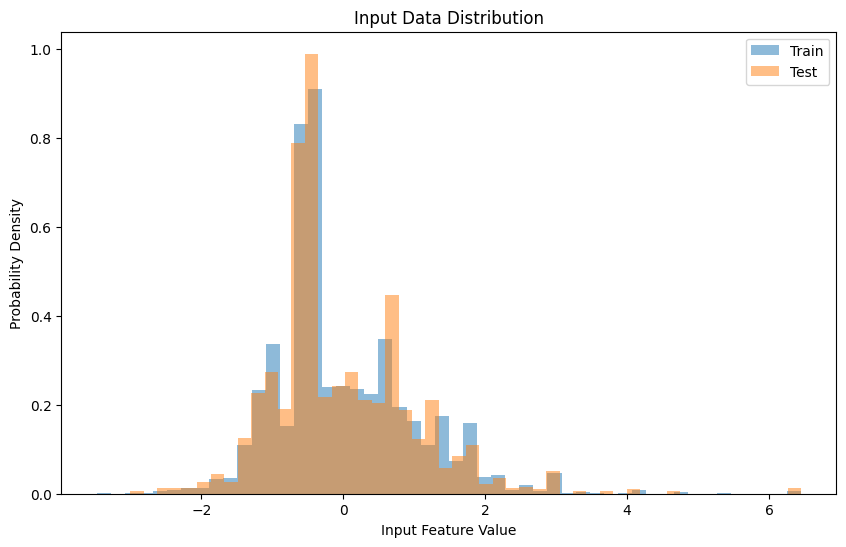

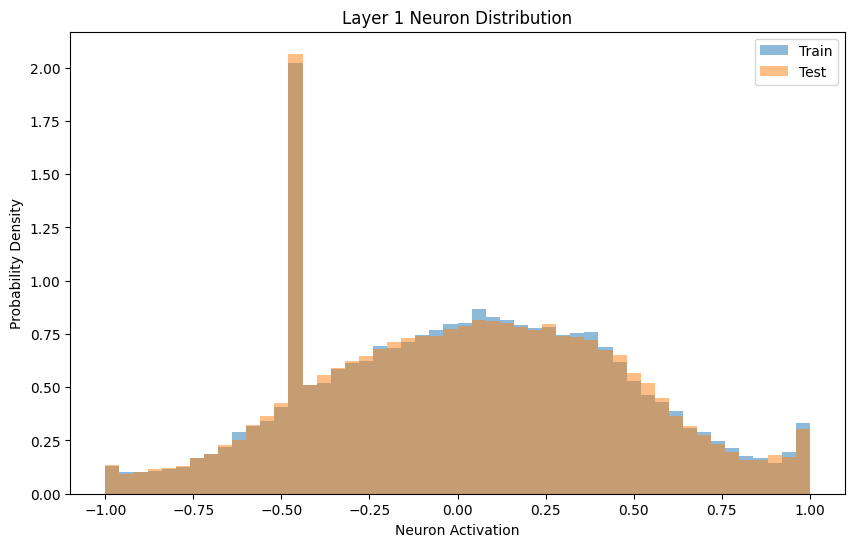

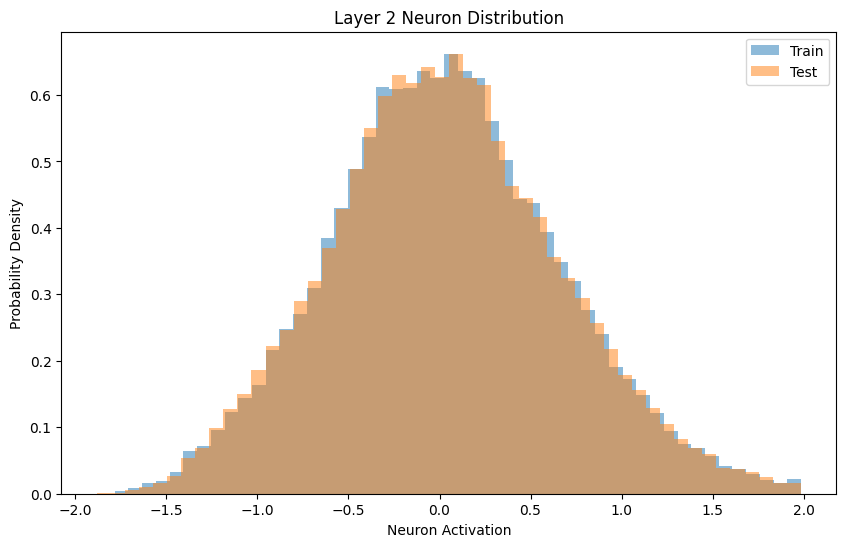

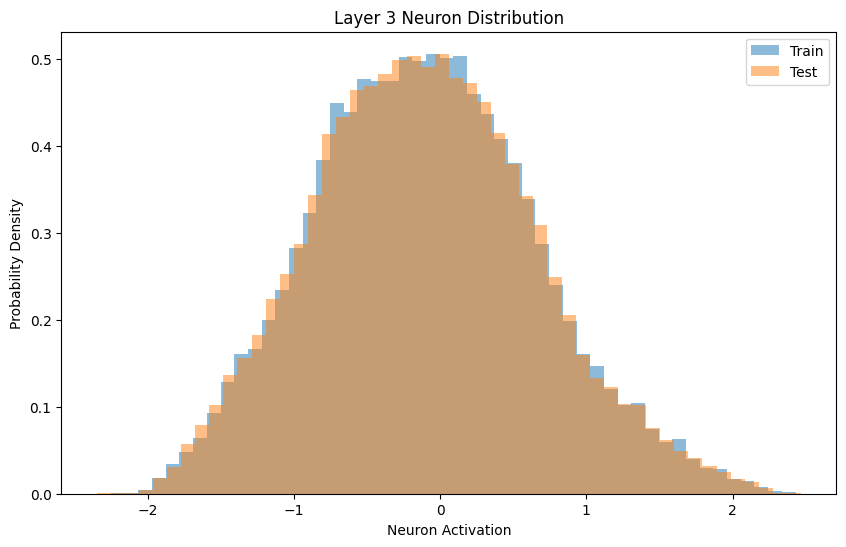

(3, 81280)


In [32]:
def neuron_distribution_for_each_layer(
        dataset_id: int,
        hidden_size: int,
        n_layers: int,
        ) -> Tuple[Array, Array]:
    """Looks at the distribution of neurons for each layer of a neural network model
    (used to compare SWIM, residual sampling, and random feature networks).
    """
    X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id)
    
    # Initialize the arrays to store the neuron distribution
    train_layers= []
    test_layers = []

    model = SWIM_MLP(
        jax.random.PRNGKey(0), 
        hidden_size, 
        n_layers,
        add_residual=True,
        sampling_method="gradient-weighted",
        activation = jnp.tanh,
        residual_scaling_factor=1.0,
        
        )
    
    model.fit(X_train, y_train)

    feat_test  = model.transform(X_train, only_last=False).reshape(n_layers, -1)
    feat_train = model.transform(X_test, only_last=False).reshape(n_layers, -1)

    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)
    print(feat_test)

    #features are shape (n_layers, n_samples, n_features)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.hist(X_train.flatten(), bins=50, alpha=0.5, label='Train', density=True)
    plt.hist(X_test.flatten(), bins=50, alpha=0.5, label='Test', density=True)
    plt.title('Input Data Distribution')
    plt.xlabel('Input Feature Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    for layer in range(n_layers):
        plt.figure(figsize=(10, 6))
        plt.hist(feat_train[layer], bins=50, alpha=0.5, label='Train', density=True)
        plt.hist(feat_test[layer], bins=50, alpha=0.5, label='Test', density=True)
        plt.title(f'Layer {layer + 1} Neuron Distribution')
        plt.xlabel('Neuron Activation')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()

    print(feat_test.shape)

neuron_distribution_for_each_layer(dataset_id=44970, hidden_size=128, n_layers=3)

I want to look at the distribution of weights (eigenvalues? absolute values of rows? distribution of (assuming iid) matrix entries?)

distribution of neurons at each layer

This is for both SWIM, Residual SWIM, random features, 